# Model Transformer

Training the Transformer model

(!) The training data on google-driver is prepared by the notebook:<br>
https://github.com/QuDataAI/IceCube/IceCube-Dataset-kaggle

A description of the architecture can be found here:<br>
https://qudata.com/projects/icecube-neutrino/en/index.html

```
DOMS_AGG_64, pars = 2.945m
dataset_trn.set(batch_size=256,  batch_max=512,   T_max=64)
dataset_val.set(batch_size=512,  batch_max=2048,  T_max=64)
------------------------------------------
                   trn    val    GPU
          FP       m/1e6  m/1e6  Gb
------------------------------------------
Tesla T4  float32  9.7    3.4    9.8    
Tesla T4  float16  7.9    2.8    5.7
A100      float32  3.1    0.93  11.3
A100      float16  2.3    0.57   5.1
```

In [1]:
!pip  install update qunet==0.0.4             # it's our lib for DL
!pip -q  install torchinfo

import os, gc, sys, copy, time, datetime, math, random,  psutil
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from   pathlib   import Path        
from   tqdm.auto import tqdm
import pyarrow, pyarrow.parquet as pq     

import torch
from   torch import nn
from   torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%%time
COPY_FROM_DRIVE     = True        # copy dataset from google drive
DATA_KIND           = "01"        # kind of data (DROP_AUX, DOMS_AGG)
#===============================================================================

class CFG:   
    T_max    =  512               # max tokens (pulses in event)
    AF       = 24*2               # number of aggregated event features

    frozen   = False              # freeze feature generator and transformer

    loss     = 'azze'             # kind of loss function: cos, prod, vMF, k2,  k2ze
    ka_reg     = 0                # kappa length regularization
    ze_reg     = 0                # zenith angle error reduction
    az_reg     = 0                # azimuthal angle error reduction

    lr         = 1e-3             # current learning rate
    batch_size = 128              # batch size for max pulses
    batch_max  = 256              # maximum allowed batch size for any length

    params     = 0                # number of parameters in the model
    samples    = 0                # number of events passed through training
    steps      = 0                # number of steps taken by the optimizer 
    last       = 0                # when was the best validation metric last
    score      = 0                # best validation metric

    device     = 'cuda'           # computing device
    dtype      = torch.float16    # model float precision

    def get(end=", "):
        """ output of config parameters """
        return "".join([f"{k}:{v}{end}" for k,v in CFG.__dict__.items() if not k.startswith("__") and k not in ["get", "par"] ])

    def plt(end="\n"):
        """ output of config parameters for the plot """
        return "".join([f" {k:7s}:{v}{end}" for k,v in CFG.__dict__.items() if not k.startswith("__") and k not in ["get","plt", "V",  "params", "device", "lr",  "best", "is_sqr","is_cat","is_pos","is_rnn","is_agg","is_emb","is_abs","is_reg","is_rho","last"] ])

print(CFG.get())
#===============================================================================
from psutil import virtual_memory
print(f'Your runtime has {(virtual_memory().total / 1024**3):.1f} gigabytes of available RAM\n')
gpu_info = !nvidia-smi
print('\n'.join(gpu_info))
#===============================================================================
def info(text, pref="", end="\n"):
    """ 
    Information about the progress of calculations (time and memory) 
    """
    gc.collect()
    ram, t = psutil.virtual_memory().used / 1024**3,  time.time()    
    print(f"{pref}{(t-info.beg)/60:5.1f}m[{t-info.last:+5.1f}s] {ram:6.3f}Gb > {text}",end=end)
    info.last = time.time(); 
info.beg = info.last = time.time()

T_max:512, AF:48, frozen:False, loss:azze, ka_reg:0, ze_reg:0, az_reg:0, lr:0.001, batch_size:128, batch_max:256, params:0, samples:0, steps:0, last:0, score:0, device:cuda, dtype:torch.float16, plt:<function CFG.plt at 0x7fed2eab7820>, 
Your runtime has 83.5 gigabytes of available RAM

Fri Apr 21 11:13:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |      0

## Copy dataset from google drive

In [3]:
%%time
info.beg = info.last = time.time()
info("Begin")

ROOT    = "/content/drive/MyDrive/IceCube/IceCube-Dataset/"    # root folder of all datasets

FOLDER_TRN  = "DOMS_AGG_64"                                        # folder of dataset
FILES_TRN   = [f"pack_{p:02d}.pt" for p in range(2, 2+1)]      # list of files to train
FILES_VAL   = ["DOMS_AGG_64/pack_01.pt"]                           # list of files to validate

if COPY_FROM_DRIVE:
    !cp "{ROOT}{FOLDER_TRN}/doms.pt"  /content/    
    !mkdir "trn"
    !mkdir "val"
    !mkdir "trn/{FOLDER_TRN}"
    
    for file in tqdm(FILES_TRN):                               # copy training dataset
        !cp "{ROOT}{FOLDER_TRN}/{file}"  "trn/{FOLDER_TRN}"    
        
    for file in tqdm(FILES_VAL):                               # copy validation dataset
        !cp "{ROOT}{file}"  "val"    

# just in case, we read all the files
FILES_TRN = [f"trn/{FOLDER_TRN}/" + en.name for en in os.scandir(f"trn/{FOLDER_TRN}/") if en.is_file()]
FILES_VAL = ["val/" + en.name for en in os.scandir("val/") if en.is_file()]
random.shuffle(FILES_TRN)    
print(FILES_TRN)
print(FILES_VAL)

  0.0m[ +0.1s]  1.413Gb > Begin
mkdir: cannot create directory ‘trn’: File exists
mkdir: cannot create directory ‘val’: File exists
mkdir: cannot create directory ‘trn/DOMS_AGG_64’: File exists


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

['trn/DOMS_AGG_64/pack_02.pt']
['val/pack_01.pt']
CPU times: user 219 ms, sys: 79.7 ms, total: 299 ms
Wall time: 6.07 s


## Class Dataset

In [4]:
class Dataset:
    """    
    Data loading class.
    The data is a dictionary in which the key is the length of the sequence.
    For the motivation for this structure, see 
    https://qudata.com/projects/icecube-neutrino/en/transformer.html#dataset
    """
    def __init__(self, files, batch_size, shuffle, device, drop, aux=False):
        """ 
        data - a dictionary, its keys are the length of the sequence in pulses, 
        and the values are a list:
                * EVENT_ID:  (B,1)    - event id                                
                * SENSOR_ID: (B,T)    - sensor_id for each pulse (token)
                * FEAT:      (B,T,F)  - F features for each pulse (token)     
                * AGG:       (B, FA)  - aggregate features
                * Y:         (B,3)    - (nx, ny, nz) - target direction (unit vector)
        """        
        self.files      = files       # list of files with data packs
        self.shuffle    = shuffle     # mix minibatch
        self.batch_size = batch_size  # batch size for max pulses
        self.batch_max  = batch_size  # maximum batch size for any number of pulses
        self.T_max      = 100         # maximum number of pulses
        self.file_id    = 0           # current file number
        self.device     = device      # computing device
        
        self.epoch      = 0           # number of epochs after loading a new pack
        self.data       = {}          # data with packs 
        self.is_T1      = 0           # minimum pulse filter
        self.is_T2     = 1e8          # filter by the maximum number of pulses
        
        info(f"Create dataset with {len(files)} files")
        
    def load_next(self, verbose = False):
        if verbose: info(f"load_next> started: file_id={self.file_id}")
        del self.data        
        self.epoch = 0
        state = torch.load(self.files[self.file_id])
        self.cols_df     = state['cols_df']
        self.cols_agg_df = state['cols_agg_df']        
        self.data = state['data']
        
        self.file_id += 1
        self.file_id = self.file_id % len(self.files)
        if verbose: info(f"load_next loaded,  tokens: {len(self.data)}")

        if self.device != 'cpu':
            for k in self.data:
                for i in range(len(self.data[k])):
                    self.data[k][i] = self.data[k][i].to(self.device)
            if verbose: info(f"load_next sended to GPU")

        self.create_batches()          # create batches
        self.batch_id   = 0            # current batch        

    def set(self, batch_size, batch_max, T_max, is_T1=0, is_T2=1e8):
        self.batch_size = batch_size
        self.batch_max  = batch_max
        self.T_max      = T_max
        self.is_T1      = is_T1
        self.is_T2      = is_T2
        self.create_batches()

    def create_batches(self):      
        """ создать ссылки на индексы начала и конца батча """         
        self.batches    = []           # list of pointers to batch  [ (T, idx1, idx2) ]
        for T,v in self.data.items():  # create pointers to batches [ (T, idx1, idx2) ]
            if self.is_T1 <= T and T <= self.is_T2:
                batch_size = min(int(self.batch_size * (self.T_max/T)**2),  self.batch_max)                
                for i in range(0, v[0].shape[0], batch_size):
                    self.batches.append((T, i, i + batch_size))

    def reset(self):        
        self.batch_id   = 0            
        if self.shuffle:
            for k in self.data:         # shuffle all samples:                
                idx = torch.randperm( len(self.data[k][0]), device=self.device )
                for i in range(len(self.data[k])):
                    self.data[k][i] = self.data[k][i][idx]            
            random.shuffle(self.batches) 

    def __next__(self):        
        if self.batch_id >= len(self.batches):
            self.epoch += 1
            self.batch_id = 0
            raise StopIteration  

        p = self.batches[self.batch_id]
        data  = self.data[p[0]]
        self.batch_id += 1                                                                #!!!!!!!!!!!!!!!!

        # (B,)    (B,T)    (B,T,F)  (B,24*2)  (B,3) 
        EVENT_ID, SENSOR_ID, FEAT,  AGG,  Y = data[0][p[1]:p[2]], data[1][p[1]:p[2]], data[2][p[1]:p[2]], data[3][p[1]:p[2], 0: CFG.AF ], data[4][p[1]:p[2]]  
        return EVENT_ID, SENSOR_ID, FEAT, AGG, Y, None # (last ERR)

    def __iter__(self):
        return self
    
    def __len__(self):
        return len(self.batches)     

#===============================================================================

def load_doms(fname="doms.pt"):
    """
    Loading sensor parameters
    """
    state = torch.load(fname)
    DOMS  = state['data']
    info(f"load doms.pt: {state['cols']},  DOMS:{DOMS.shape}")
    return DOMS

DOMS = load_doms()
print("DOMS:", DOMS.shape)

  0.1m[ +6.1s]  1.225Gb > load doms.pt: ['x', 'y', 'z', 'core', 'a', 'r'],  DOMS:torch.Size([5160, 6])
DOMS: torch.Size([5160, 6])


##  Create Dataset

In [5]:
dataset_trn = Dataset(FILES_TRN,  batch_size=CFG.batch_size, shuffle=True, device='cpu', drop=False)
dataset_val = Dataset(FILES_VAL,  batch_size=CFG.batch_size, shuffle=True, device='cpu', drop=False)

dataset_trn.load_next(True)
info(f"trn: loaded, next file_id {dataset_trn.file_id}")

dataset_val.load_next(True)
random.shuffle(dataset_val.batches)  # not large first!!!
info(f"val: loaded, next file_id {dataset_val.file_id}")

dataset_trn.file_id = 0 # set first file for loading
dataset_val.file_id = 0 
info(CFG.get())

  0.1m[ +0.1s]  1.229Gb > Create dataset with 1 files
  0.1m[ +0.1s]  1.234Gb > Create dataset with 1 files
  0.1m[ +0.1s]  1.240Gb > load_next> started: file_id=0
  0.1m[ +0.8s]  2.207Gb > load_next loaded,  tokens: 54
  0.1m[ +0.1s]  2.208Gb > trn: loaded, next file_id 0
  0.1m[ +0.1s]  2.208Gb > load_next> started: file_id=0
  0.1m[ +0.8s]  3.325Gb > load_next loaded,  tokens: 53
  0.1m[ +0.1s]  3.326Gb > val: loaded, next file_id 0
  0.1m[ +0.1s]  3.339Gb > T_max:512, AF:48, frozen:False, loss:azze, ka_reg:0, ze_reg:0, az_reg:0, lr:0.001, batch_size:128, batch_max:256, params:0, samples:0, steps:0, last:0, score:0, device:cuda, dtype:torch.float16, plt:<function CFG.plt at 0x7fed2eab7820>, 


## Plot training history

In [6]:
def plot(history, checks, labels, xmin=0, xmax=None, ymin=1.0, ymax=1.2, ticks=21, info="", w=12, h=5, title_short=False):
    """ 
    Creating a trainig process plot
    (CFG.samples, score_trn, score_val, kappa_trn, kappa_val, CFG.lr, tm_trn, tm_val) 
    """
    from matplotlib.ticker import FormatStrFormatter        
    xmax = len(history) if xmax is None else xmax
    hist = np.array(history)[xmin: xmax].transpose()   
    chck = np.array(checks)    
    
    plt.figure(figsize=(w,h), facecolor ='w')
    ax1 = plt.subplot(1,1,1); ax1.grid(ls=':')     
    plt.xlabel('1m samples'); plt.ylabel('error');     
    plt.text((hist[0,0]+0.8*(hist[0,-1]-hist[0,0]))/1e6, ymin+0.8*(ymax-ymin), info, fontname="monospace", fontsize=8)
    #plt.text(hist[0,0]/1e6, ymin, CFG.plt(), fontname="monospace", fontsize=8)
    ax1.set_ylim(ymin,ymax);  ax1.set_yticks(np.linspace(ymin, ymax, ticks))  
    ax1.plot   (hist[0]/1e6, hist[1], 'darkblue', linewidth=0.5);                 # err trn
    ax1.plot   (hist[0]/1e6, hist[2], 'g', linewidth=1.5);                        # err val
    if ymin < 1.00 and 1.00 < ymax: ax1.axhline(y=1.000, color='gray', linestyle='-', linewidth=0.5)
    if ymin < 1.10 and 1.10 < ymax: ax1.axhline(y=1.100, color='gray', linestyle='-', linewidth=0.5)
    if ymin < 1.02 and 1.02 < ymax: ax1.axhline(y=1.020, color='gray', linestyle='-', linewidth=0.5)    
    best = 1.51
    for c in chck:
        if c[0] >= hist[0,0] and c[0] <= hist[0,-1]:
            ax1.scatter(c[0]/1e6, c[1], s=7, c='g', edgecolors='black')            
            if c[1] < best: best = c[1]

    if title_short:
        plt.title(fr"[{CFG.score:.3f}] (trn:{hist[1,-1]:.4f}, val:{hist[2,-1]:.4f}, best:{best:.4f}) (az:{hist[3][-1]:.3f}, ze:{hist[4][-1]:.3f}, ka:{hist[-4][-1]:.2f})")
    else:
        plt.title(fr"[{CFG.score:.3f}] (trn:{hist[1,-1]:.4f}, val:{hist[2,-1]:.4f}, best:{best:.4f}) (az:{hist[3][-1]:.3f}, ze:{hist[4][-1]:.3f}, ka:{hist[-4][-1]:.2f}) > s={hist[0,-1]/1e6:.0f}m; (trn:{hist[-2,-1]:.2f}, val:{hist[-1,-1]:.2f})m/$10^6$) tot:{hist[-2].sum():.1f}m; pars={ModelCFG.params/1000:.0f}k")                           
    ax1.legend(['trn', 'val'], loc='upper left', frameon = False)        
    ax1.tick_params(axis='y', colors='g')
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    for lb in labels:    
        if lb[0] >= hist[0,0] and lb[0] <= hist[0,-1]:
            ax1.vlines(lb[0]/1e6, ymin, ymax, linestyles=':', color='gray')
            ax1.text(lb[0]/1e6,   ymin+0.001, lb[2])
    if False:
        ax2 = ax1.twinx(); ax2.set_ylim(0.000, 1.200) #ax2.set_ylabel("loss");     
        ax2.plot(hist[0]/1e6, hist[3], "--",  color='darkgreen', linewidth=1)    # az_err
        ax2.plot(hist[0]/1e6, hist[4], "--", color='g', linewidth=1)             # ze_err
        ax2.legend(['az', 'ze'], loc='center right', frameon = False)
        ax2.tick_params(axis='y', colors='g')
        ax2.spines["right"].set_position(("outward", 70))
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    ax3 = ax1.twinx(); 
    ax3.set_yscale('log'); ax3.set_ylim(1e-6, 1e-1) #ax3.set_ylabel("log10(lr)");     
    ax3.plot(hist[0]/1e6, hist[-3], ":", color='darkred')             # lr    
    ax3.legend(['lr'], loc='upper right', frameon = False)
    ax3.tick_params(axis='y', colors='darkred')
    
    if True:
        ax4 = ax1.twinx(); #ax4.set_ylabel("kappa")    
        ax4.plot(hist[0]/1e6, hist[-4], "-r", linewidth=0.5, alpha=0.5)             # kappa
        ax4.legend(['kappa'], loc='upper center', frameon = False)
        ax4.spines["right"].set_position(("outward", 40))
        ax4.set_ylim((0, max(1, np.max(hist[-4]))))
        ax4.tick_params(axis='y', colors='r')

    plt.show()    

def vector2angles(n, eps=1e-8):
    """  Get spherical angles of vector n: (B,3) """                
    n = n / (np.linalg.norm(n, axis=1, keepdims=True) + eps)                             
    azimuth = np.arctan2( n[:,1],  n[:,0])    
    azimuth[azimuth < 0] += 2*np.pi                                
    zenith = np.arccos( n[:,2].clip(-1,1) )                                    
    return azimuth, zenith    


## Model

In [7]:
from qunet.old import MLP, CNN, TransformerBlock, PointsBlock

#===============================================================================

class FeatureGenerator(nn.Module):
    def __init__(self, cfg, doms, V=5160):
        """ 
        Feature generator. 
        Gets the original pulse features, returns a tensor (B,T,E)
        V - number of sensors (embedding vocab) from sensors_df    
        """
        super(FeatureGenerator, self).__init__()      

        dom_feat = 4                                 # {x,y,z,core}
        if cfg.is_abs and not cfg.is_rho:            # {x,y,z,core,a} 
            dom_feat = 5        
        else:                                        # {x,y,z,core,a,r}
            dom_feat = 6          

        self.dom = nn.Embedding(V, dom_feat,_weight=doms[:,:dom_feat]).requires_grad_(False)
        self.emb = nn.Embedding(V, cfg.SE) if cfg.is_emb else None # sensor embedding                
             
        self.fin = MLP(dict(input=24, hidden=64, output=7)) if cfg.is_fin else None

        F = dom_feat+cfg.F                           # {x,y,z,core [,a]} + {t,q,aux}
        if cfg.is_fin:
            F += self.fin.bias.shape[0]
        if cfg.is_emb:  
            F += cfg.SE                              # add sensor SE embedding
        self.mlp = MLP(dict(input=F, hidden=cfg.Hin, output=cfg.n_embd)) if cfg.Hin > 0 else nn.Linear(F, cfg.n_embd)

    def forward(self, SENSOR_ID, FEAT):                       
        s  = self.dom(SENSOR_ID)                     # (B,T,5)   x,y,z,core,a,r  
        if self.emb is None:
            x  = torch.cat([s, FEAT], dim=2)         # (B,T,E0)  pulse feat  +  'aux','q','t'    
            if self.fin is not None:
                T = x.shape[1]
                f = self.fin(FEAT[24:])              # (B,7)
                f = f.unsqueeze(1).expand(-1,T,-1)   # (B,T,7)
                x = torch.cat([x,f], dim=2)          # (B,T,E0+7) = (B,T,16)
            x  = self.mlp(x)                         # (B,T,E)   increase num of features            
        else:
            em = self.emb(SENSOR_ID)
            x  = torch.cat([s, FEAT, em], dim=2)     # (B,T,F+6+SE) concat with pulse features       
            x  = self.mlp(x)                         # (B,T,E)   increase num of features            
        return x
#-------------------------------------------------------------------------------

class Transformer(nn.Module):
    def __init__(self, cfg, drop=0):
        """ 
        Transformer (B,T,E) -> (B,T,E) 
        """
        super().__init__()     
        self.blocks= nn.ModuleList([TransformerBlock(dict(emb=cfg.n_embd, res=cfg.res, att={'heads': 8})) for _ in range(cfg.L)])         
        self.drop = nn.Dropout(drop)
        self.ln   = nn.LayerNorm(cfg.n_embd)        

    def forward(self, x):
        x   = self.drop(x)              
        x   = self.ln(x)                             # layer normalization (? batch)

        for i, block in enumerate(self.blocks):  
            if CFG.frozen and self.training and i > CFG.L_frozen: torch.set_grad_enabled(True) 
            x = block(x)                             # (B,T,E)            
        return x
#-------------------------------------------------------------------------------

class Integrator(nn.Module):
    def __init__(self, cfg):
        """ 
        Collects features from all pulses into one vector (B,T,E) -> (B,E) 
        """
        super().__init__()               
        self.ln    = nn.LayerNorm(cfg.n_embd)        
        self.rnn   = nn.GRU(cfg.n_embd, cfg.Eh, batch_first=True) if cfg.is_rnn else None
        self.cfg   = cfg

    def forward(self, x):    
        x = self.ln(x)                           # !!??
        if self.rnn is None:
            if self.cfg.is_max:                  # (B,2*E)
                x =torch.cat([x.mean(dim=1), x.amax(dim=1)], dim=1)
            else:
                x = torch.mean(x, dim=1)         # (B,E) 
        else:             
            _, x = self.rnn(x)                   # (1,B,Eh) integrate all pulses            
            x = torch.squeeze(x, dim=0)          # (B,Eh)                        
        return x
#-------------------------------------------------------------------------------

class Model(nn.Module):
    def __init__(self,cfg, doms):
        """ 
        Prediction model (common for regressor and classifier) 
        """
        super().__init__()    
        self.cfg = copy.deepcopy(cfg)           
        self.gen = FeatureGenerator(cfg, doms)        
        if cfg.tri == 0:
            self.att = Transformer(cfg)
        else:
            self.atts= nn.ModuleList([Transformer(cfg) for _ in range(cfg.tri)])         
        self.sum = Integrator(cfg)
         
        self.is_agg = cfg.is_agg
        if cfg.is_rnn:
            Ein  = cfg.Eh
        else: 
            Ein  = 2*cfg.n_embd  if cfg.is_max else cfg.n_embd
            if self.cfg.tri > 0:
                Ein *= self.cfg.tri
        if cfg.is_agg:
            Ein += cfg.AF
        Eout = 3 if cfg.is_reg else cfg.nums[0]*cfg.nums[1]  

        self.mlp = MLP(dict(input=Ein, hidden=cfg.Hout, output=Eout))        

    def forward(self, SENSOR_ID, FEAT, AGG, Y):    
        if CFG.frozen: torch.set_grad_enabled(False) 

        x = self.gen(SENSOR_ID, FEAT)            # (B,T,E)
        if self.cfg.tri == 0:
            x = self.att(x)                      # (B,T,E)
            x = self.sum(x)                      # (B,E)           
        else:
            res = []
            for att in self.atts:
                res.append( self.sum (att(x)) )
            x = torch.cat(res, dim=-1)           # (B,E*tri)
        
        if CFG.frozen and self.training: torch.set_grad_enabled(True) 

        if self.is_agg:
            AGG = torch.clip(AGG, -10, 10)       # на всякий случай
            x = torch.cat([x, AGG], dim=1)       # (B, Eh+AF) or (B, E+AF)

        x = self.mlp(x)                          # (B,...)        
        return x

#-------------------------------------------------------------------------------

class Regression(nn.Module):
    def __init__(self,cfg, doms):
        """ 
        Regression model - predict three direction components
        """
        super(Regression, self).__init__()              
        self.model = Model(cfg, doms)          

    def forward(self, SENSOR_ID, FEAT, AGG, Y, eps=1e-8):    
        x = self.model(SENSOR_ID, FEAT, AGG, Y) # (B,3)

        if   CFG.loss == 'cos':
            kappa = torch.norm(x, dim=1, keepdim=True).clip(eps)
            y = x / kappa                          
            cos = (y*Y).sum(dim=1).mean()
            loss = ( 1 - cos.mean() ) + CFG.ka_reg * (x*x).sum(dim=1).mean()  #  * B / CFG.batch_size  # !!!???
        elif CFG.loss == 'prod':
            loss = -((x*Y).sum(dim=1)).mean() + CFG.ka_reg * (x*x).sum(dim=1).mean()   
        elif CFG.loss == 'vMF':
            kappa = torch.norm(x, dim=1, keepdim=True).clip(eps)
            logC  = -kappa + torch.log( ( kappa+eps )/( 1-torch.exp(-2*kappa)+2*eps ) )
            loss =  -( (x*Y).sum(dim=1) + logC ).mean() 
        elif CFG.loss == 'k2':                                
            loss = -((x*Y).sum(dim=1)).mean() + 0.5 * (x*x).sum(dim=1).mean()              
        elif CFG.loss == 'azze':
            kappa = torch.norm(x, dim=1, keepdim=True)
            y = x / kappa.clip(eps)              
            r2y   =  y[:,0]*y[:,0] + y[:,1]*y[:,1] 
            r2Y   =  Y[:,0]*Y[:,0] + Y[:,1]*Y[:,1]
            ryY   =  torch.sqrt(r2y*r2Y)

            cos  = (y*Y).sum(dim=1)
            cosA = (y[:,0]*Y[:,0] + y[:,1]*Y[:,1]) / ryY.clip(eps)                
            cosZ = y[:,2]*Y[:,2] + ryY      # cos(theta_y-theta_Y)

            loss = 1 - cos.mean()               \
                 + CFG.az_reg * (1-cosA.mean()) \
                 + CFG.ze_reg * (1-cosZ.mean()) \
                 + CFG.ka_reg * (x*x).sum(dim=1).mean()

        with torch.no_grad():                
            kappa = torch.norm(x.detach(), dim=1, keepdim=True).clip(eps)                        
            y = x.detach() / kappa
            ang_err, az_err, ze_err = Phys.angle_errors(y, Y, eps=eps)            
        return loss, y.detach(), ang_err.detach(), az_err.detach(), torch.abs(ze_err.detach()),  kappa.detach()

#-------------------------------------------------------------------------------

class Classifier(nn.Module):
    def __init__(self, cfg, doms):
        """ 
        Classification model - predicting the direction number
        """
        super().__init__()               
        self.model = Model(cfg, doms)      
        self.cfg   = cfg    

    def forward(self, SENSOR_ID, FEAT, AGG, Y, eps=1e-8):    
        x = self.model(SENSOR_ID, FEAT, AGG, Y) # (B,3)

        kappa = torch.square(x).mean()
        az_true, ze_true = Phys.vector2angles(Y)
        id_true = Phys.angles2index(az_true, ze_true, n_az=self.cfg.nums[0], n_ze=self.cfg.nums[1])
        CE_loss = nn.CrossEntropyLoss()
        loss = CE_loss(x, id_true) + CFG.ka_reg * kappa
        pred = x.detach().argmax(axis=1)
        az_pred, ze_pred = Phys.index2angles(pred, n_az=self.cfg.nums[0], n_ze=self.cfg.nums[1])
        y = Phys.angles2vector(az_pred, ze_pred)        
        ang_err, az_err, ze_err = Phys.angle_errors(y, Y, eps=eps)            
        return loss, y.detach(), ang_err.detach(), az_err.detach(), torch.abs(ze_err.detach()), torch.sqrt(kappa.detach())

#-------------------------------------------------------------------------------

class Phys:
    """
    General helper methods for working with  geometry
    """
    def angle_errors(n1, n2, eps=1e-8):
        """ 
        Calculate angles between two unit (!!!)  vectors:: n1,n2: (B,3) 
        return: (B,) 
        """
        with torch.no_grad():
            cos = (n1*n2).sum(axis=1)                     # angles between vectors
            angle_err = torch.arccos( cos.clip(-1,1) )    
        
            r1   =  n1[:,0]*n1[:,0] + n1[:,1]*n1[:,1]    # angles between vectors in (x,y)    
            r2   =  n2[:,0]*n2[:,0] + n2[:,1]*n2[:,1]
            norm = torch.sqrt(r1*r2)
            cosX = (n1[:,0]*n2[:,0] + n1[:,1]*n2[:,1]) / norm.clip(eps)    
            azimuth_err = torch.arccos( cosX.clip(-1,1) )
                                
            zerros = norm < eps                            # azimuth angle not defined
            azimuth_err[zerros] = torch.rand((len(n1[zerros]),), device=n1.device)*torch.pi
    
            zenith1  = torch.arccos( n1[:,2].clip(-1,1) )
            zenith2  = torch.arccos( n2[:,2].clip(-1,1) )
            zenith_err = zenith2 - zenith1    
        
        return angle_err, azimuth_err, zenith_err

    def vector2angles(n, eps=1e-8):
        """  
        Get spherical angles of vector n: (B,3) 
        """                
        n = n / torch.norm(n, dim=1, keepdim=True).clip(eps)
                                
        azimuth = torch.arctan2( n[:,1],  n[:,0])    
        azimuth[azimuth < 0] += 2*torch.pi
                                
        zenith = torch.arccos( n[:,2].clip(-1,1) )                                
    
        return azimuth, zenith

    def angles2vector(azimuth, zenith):
        """ 
        Add unit vector components from (azimuth,zenith) to the DataFrame df 
        """
        nx = (torch.sin(zenith) * torch.cos(azimuth)).view(-1,1)
        ny = (torch.sin(zenith) * torch.sin(azimuth)).view(-1,1)
        nz = torch.cos(zenith).view(-1,1)
        return torch.cat([nx,ny,nz], dim=1)

    def angles2index(azimuth, zenith, n_az, n_ze):
        """ 
        Convert angles to direction number.
        naz, n_ze - number of bins for each corner
        """
        az = torch.floor(n_az * azimuth / (2*np.pi)).clip(0,n_az-1)
        ze = torch.floor(n_ze * (torch.cos(zenith)+1)/2).clip(0,n_az-1)
        return (az*n_ze + ze).to(torch.long)

    def index2angles(index, n_az, n_ze):
        """ 
        Transfer the direction number to angles. 
        naz, n_ze - number of bins for each corner
        """
        az = (index // n_ze)  
        ze = torch.arccos( (2*((index - az*n_ze)/n_ze) - 1).clip(-1,1) )
        az = az * (2*torch.pi) / n_az
        return az, ze        

#===============================================================================

def load_model(fname, doms, verbose=True):
    """
    Load model from pytorch pt-file
    """
    state = torch.load(fname)
    if 'is_fin'    not in state['config']: state['config']['is_fin']    = 0    
    if 'tri'       not in state['config']: state['config']['tri']       = 0
    if 'res'       not in state['config']: state['config']['res']       = 1
    if 'is_max'    not in state['config']: state['config']['is_max']    = 0
    if 'is_rho'    not in state['config']: state['config']['is_rho']    = 0        
    if 'n_embd'    not in state['config']: state['config']['n_embd']    =  state['config']['E']
    if 'n_head'    not in state['config']: state['config']['n_head']    =  8
    if 'causal'    not in state['config']: state['config']['causal']    =  False    
    if 'drop_attn' not in state['config']: state['config']['drop_attn'] =  0    
    if 'drop_mlp'  not in state['config']: state['config']['drop_mlp']  =  0    
    if 'hidden'    not in state['config']: state['config']['hidden']    =  4    
    if 'fun'       not in state['config']: state['config']['fun']       =  'gelu'     
    if 'poly'      not in state['config']: state['config']['poly']      = False

    if verbose: print(state['config'])    
    class ModelConfig(object): pass     
    cfg = ModelConfig()            
    for key in state['config']:
        setattr(cfg, key, state['config'][key])
    #cfg.res = 2         
    if cfg.is_reg:
        model = Regression(cfg, doms)
    else:
        model = Classifier(cfg, doms)
    model.load_state_dict(state['model'])     

    history     = state.get('history',[])
    labels      = state.get('labels', [])
    checks      = state.get('checks', [])

    CFG.samples = history[-1][0] if len(history) else 0       
    CFG.steps   = state.get('steps', 0)
    CFG.last    = state.get('last',  0)
    CFG.score   = state.get('score', 100)
    
    return model, history, labels, checks

#===============================================================================

def model_state(model):
    """
    Model state for loading
    """
    cfg = model.model.cfg if model.model is not None else model.cfg
    state = {'info':      "IceCube at", 
             'date':      datetime.datetime.now(),   
             'config':    dict([(k,v) for k,v in cfg.__dict__.items() if not k.startswith("__")]),
             'model' :    model.state_dict(),        
             'optimizer': optimizer.state_dict(),    
             'history':   history,
             'labels':    labels,
             'checks':    checks,
             'score':     CFG.score,
             'steps':     CFG.steps,
             'samples':   CFG.samples,
             }    
    return state

#-------------------------------------------------------------------------------
def save_model(model, fname):              
    state = model_state(model)  
    torch.save(state, fname)

def save_best_model(model, score, folder="/content/drive/MyDrive/IceCube/IceCube-Models/"):              
    cfg = model.model.cfg if model.model is not None else model.cfg
    CFG.last = CFG.samples    
    CFG.score= round(score, 5)        
    CFG.best = f'att_{score:.4f}_D{DATA_KIND}_A{ModelCFG.arch}_F{ModelCFG.F}_AF{ModelCFG.AF}_E{ModelCFG.n_embd}_L{cfg.L}_Eh{ModelCFG.Eh}_Hout{ModelCFG.Hout}_T{CFG.T_max}'
    state = model_state(model)  
    torch.save(state, folder+CFG.best+".pt")

def save_model_checkpoint(model,  error_val, error_trn, folder="/content/drive/MyDrive/IceCube/IceCube-Models/checkpoints/"):                
    state = model_state(model)  
    now = datetime.datetime.now().strftime("%m-%d %H:%M:%S")
    fname = f'{now} er_val_{error_val:.4f}_trn_{error_trn:.4f} az_{history[-1][3]:.3f} ze_{history[-1][4]:.3f} ka_{history[-1][-4]:.3f}.pt'    
    torch.save(state, folder+fname)

## Model Create

In [8]:
class ModelCFG:    
    AF    =  24*2       # event features 
    F     =   3         # pulse features> 3:(aux, q, t) or 2:(q, t) next add 4:(x,y,z,core,a)
    SE    =   4         # DOM embedding dim (if is_cat == 0 equal E)
    
    L     = 10          # transformer layers
    Eh    = 256         # embedding after rnn (if not or mean
    Hin   = 256         # hidden layer in feature generator     (4+8=12) -> 32 -> 64
    Hout  = 2048        # neurons in hidden layer of output MLP  64 -> 256 -> 3    

    data     = DATA_KIND
    arch     = ""    
    is_max   = 0         # add max to mean during aggregation
    is_agg   = 1         # use aggregated event features
    is_emb   = 0         # add sensor embedding
    is_abs   = 1         # add absorption
    is_rho   = 1         # add r = (x**2+y**2)**0.5    
    
    is_fin   = 0         # add aux0 agg features to every pulse
    is_cat   = 1         # sensor embedding attach to features    
    is_rnn   = 1         # use RNN output    
    tri      = 0         # use multiple parallel transformers    
    T_max    =10

    is_reg   = 1         # regression model otherwise classifier    

    nums     = [180, 60] # number of partitions of azimuth and zenith angles (classifier)
    #------------------------------- Transformer:    
    n_embd:     int   = 128     # embedding dimension    
    n_head:     int   =  16     # number of heads in attention (divisor of n_embd)
    res:        int   =  2     # skip-connection (0: none, 1: single, 2: trainable)

CFG.samples = 0      # was training samlpes
CFG.score   = 100    # best model error
history = []         # learning history
labels  = []         # notes in history
checks  = []         # chekpoints (save best model)

LOAD_MODEL = False   # load old model
if LOAD_MODEL: 
    model, history, labels, checks = load_model('/content/drive/MyDrive/IceCube/IceCube-Models/IceCube-all/att_0.9986_D01_A_F3_AF48_E128_L12_Eh256_Hout2048_T256.pt', DOMS)
else:
    model = Regression(ModelCFG, DOMS)        

info(CFG.get())  
CFG.params = ModelCFG.params = sum(p.numel() for p in model.parameters() if p.requires_grad) 

model = model.to(CFG.device)
print(CFG.device)
display(summary(model, col_names=["num_params","trainable"], depth=5))

  0.1m[ +0.2s]  3.359Gb > T_max:512, AF:48, frozen:False, loss:azze, ka_reg:0, ze_reg:0, az_reg:0, lr:0.001, batch_size:128, batch_max:256, params:0, samples:0, steps:0, last:0, score:100, device:cuda, dtype:torch.float16, plt:<function CFG.plt at 0x7fed2eab7820>, 
cuda


Layer (type:depth-idx)                        Param #                   Trainable
Regression                                    --                        Partial
├─Model: 1-1                                  --                        Partial
│    └─FeatureGenerator: 2-1                  --                        Partial
│    │    └─Embedding: 3-1                    (30,960)                  False
│    │    └─MLP: 3-2                          --                        True
│    │    │    └─Linear: 4-1                  2,560                     True
│    │    │    └─Linear: 4-2                  32,896                    True
│    └─Transformer: 2-2                       --                        True
│    │    └─ModuleList: 3-3                   --                        True
│    │    │    └─TransformerBlock: 4-3        2                         True
│    │    │    │    └─LayerNorm: 5-1          256                       True
│    │    │    │    └─SelfAttention: 5-2      66,048         

## Scheduler

In [9]:
from qunet.optim import ExpScheduler, CosScheduler

CFG.frozen     = False   
CFG.L_frozen   = 9
#labels.append([CFG.samples, CFG.score, f'unfrozen']) 

dataset_trn.set(batch_size=256,  batch_max=512,   T_max=64)
dataset_val.set(batch_size=512,  batch_max=2048,  T_max=64)

CFG.lr         =  1e-3

CFG.az_reg     = 0
CFG.ze_reg     = 0
CFG.ka_reg     = 0
CFG.loss       = 'k2'       #'cos' vMF k2

#labels.append([CFG.samples, CFG.score, f'ALL_512']) 

CFG.params = ModelCFG.params = sum(p.numel() for p in model.parameters() if p.requires_grad) 

display(summary(model, col_names=["num_params","trainable","params_percent"], depth=4))
model.to(CFG.device)


optimizer = torch.optim.Adam(model.parameters(),  lr=CFG.lr) #  weight_decay = CFG.L2
scheduler = ExpScheduler(optimizer)
scheduler.set(lr1=None,  lr2=1e-4, samples=20e6)

Layer (type:depth-idx)                        Param #                   Trainable                 Param %
Regression                                    --                        Partial                        --
├─Model: 1-1                                  --                        Partial                        --
│    └─FeatureGenerator: 2-1                  --                        Partial                        --
│    │    └─Embedding: 3-1                    (30,960)                  False                       1.04%
│    │    └─MLP: 3-2                          --                        True                           --
│    │    │    └─Linear: 4-1                  2,560                     True                        0.09%
│    │    │    └─Linear: 4-2                  32,896                    True                        1.11%
│    └─Transformer: 2-2                       --                        True                           --
│    │    └─ModuleList: 3-3                   

## Train

  0.2m[ +0.3s]  3.500Gb > Good luck!


  0%|          | 0/20 [00:00<?, ?it/s]

it:   1v[ 0]  100%  loss=-0.00124  error: 1.5261 (az: 1.551, ze: 0.682)  ( 693,  55,   3)   tm=27.4ms/step,  0.58m/1e6,  steps=1267         

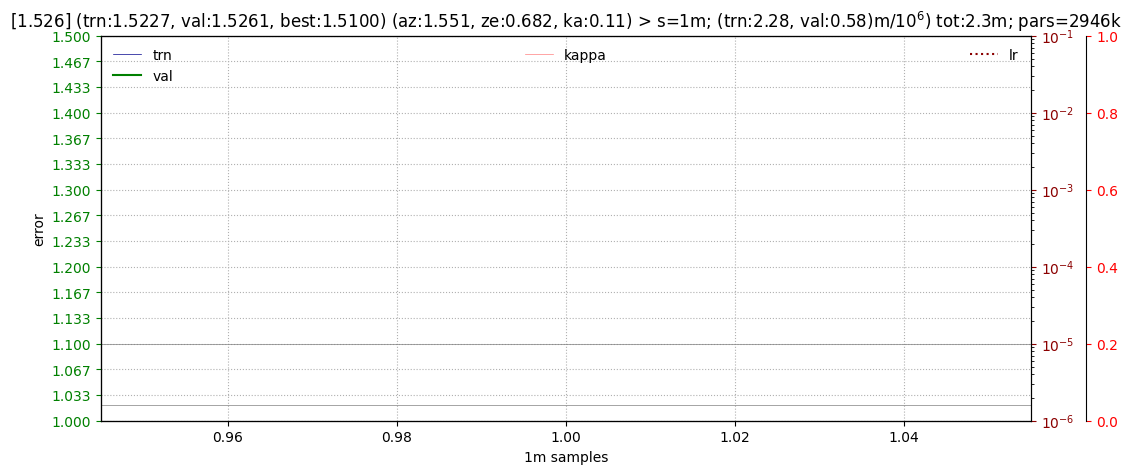

it:   2v[ 0]  100%  loss=-0.00416  error: 1.5069 (az: 1.512, ze: 0.706)  ( 838,  50,   3)   tm=27.4ms/step,  0.58m/1e6,  steps=1267         

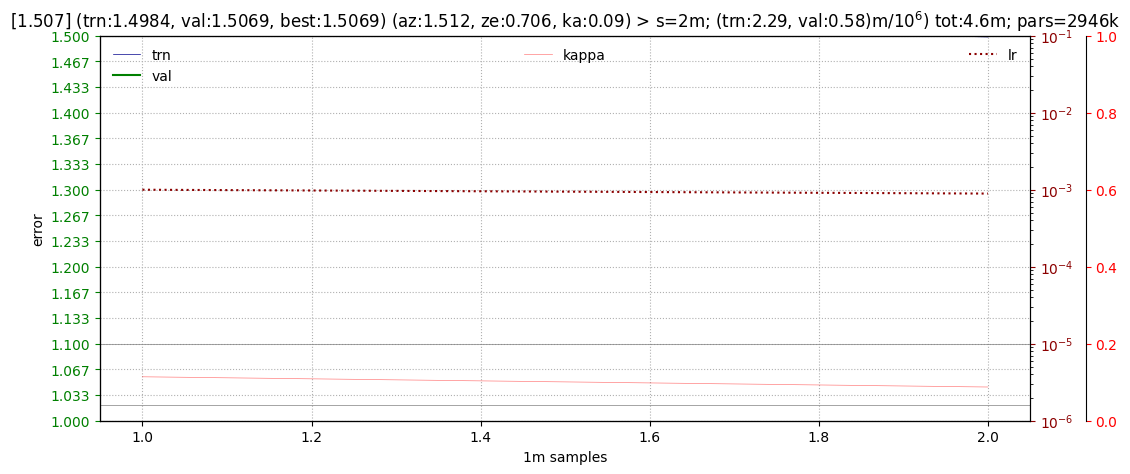

it:   3v[ 0]  100%  loss=-0.00369  error: 1.4989 (az: 1.487, ze: 0.997)  ( 512,  64,   3)   tm=27.5ms/step,  0.58m/1e6,  steps=1267         

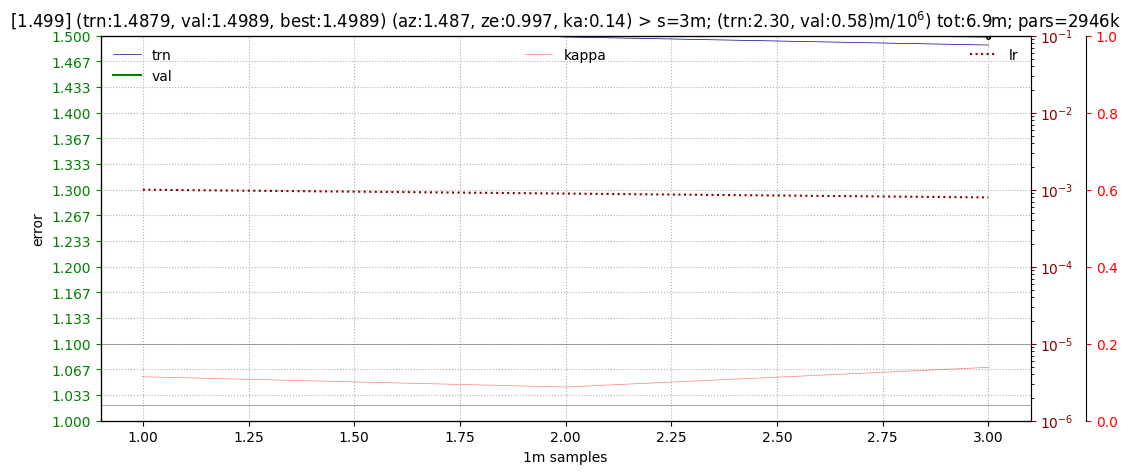

it:   4v[ 0]  100%  loss=-0.00729  error: 1.4733 (az: 1.480, ze: 0.791)  ( 512,  64,   3)   tm=27.5ms/step,  0.58m/1e6,  steps=1267         

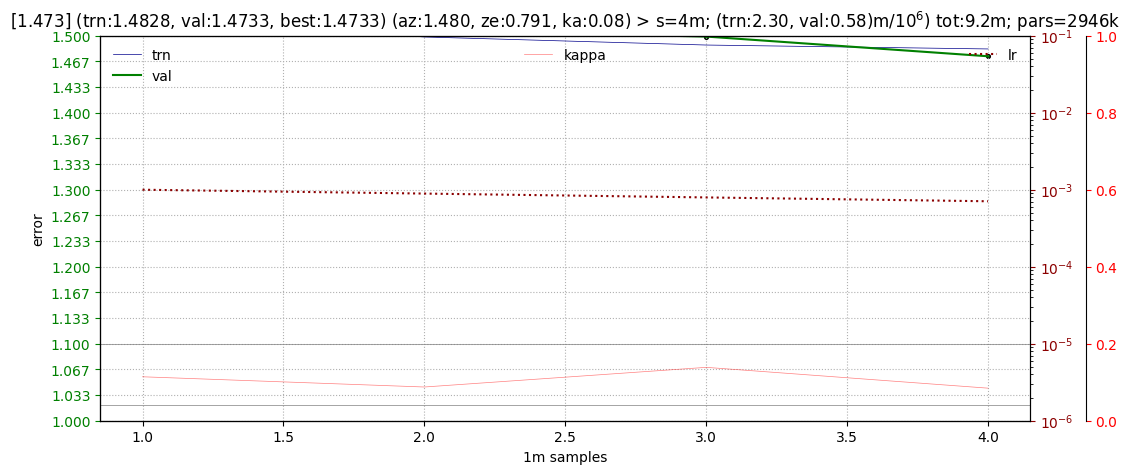

it:   5v[ 0]  100%  loss=-0.04865  error: 1.3390 (az: 1.389, ze: 0.738)  ( 668,  56,   3)   tm=27.6ms/step,  0.58m/1e6,  steps=1267         

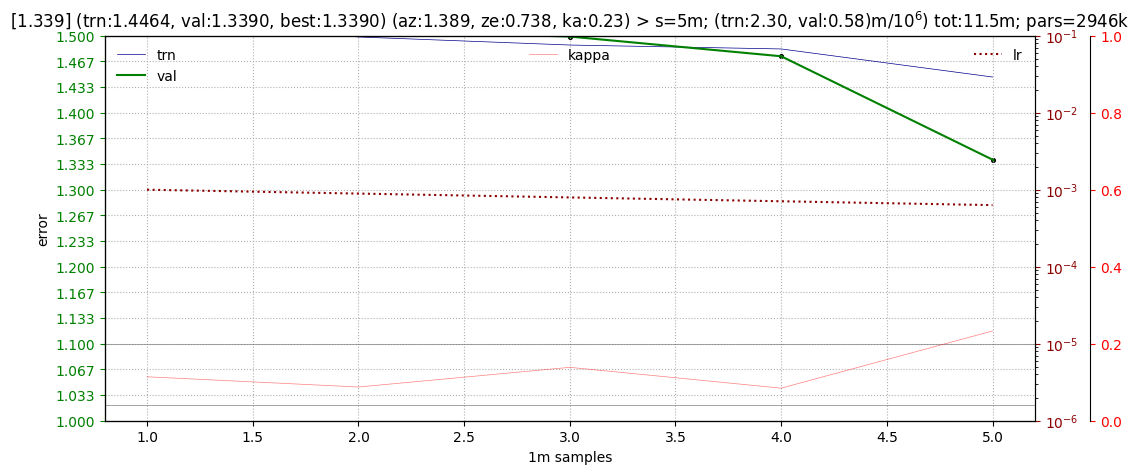

it:   6v[ 0]  100%  loss=-0.12007  error: 1.1333 (az: 1.168, ze: 0.635)  (2048,  28,   3)   tm=27.6ms/step,  0.58m/1e6,  steps=1267         

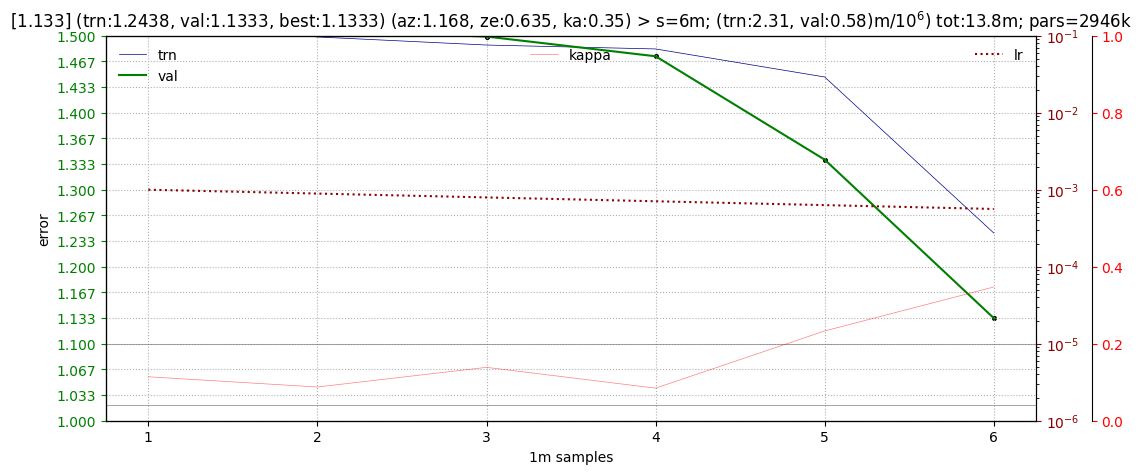

it:   7v[ 0]  100%  loss=-0.13472  error: 1.0862 (az: 1.117, ze: 0.696)  ( 512,  64,   3)   tm=27.5ms/step,  0.58m/1e6,  steps=1267         

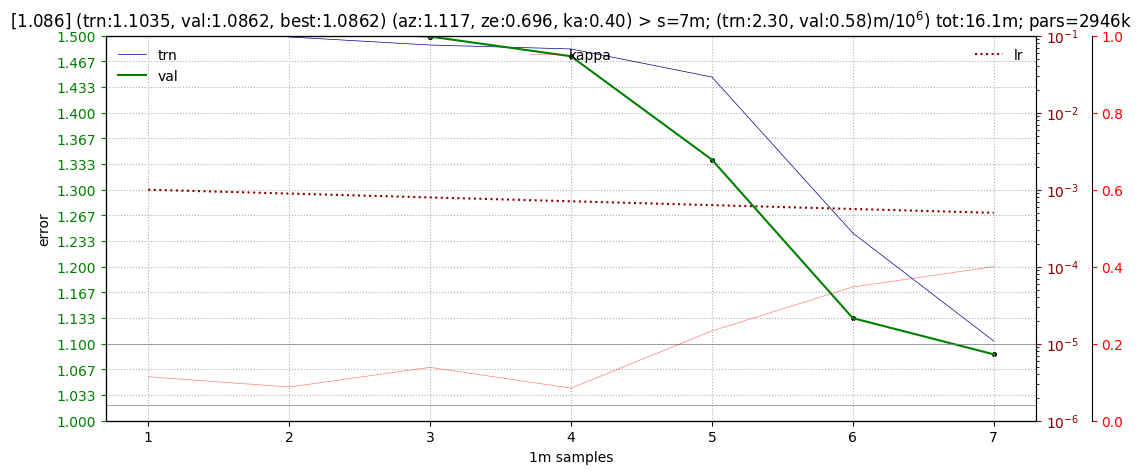

it:   8v[ 0]  100%  loss=-0.14052  error: 1.0712 (az: 1.102, ze: 0.680)  ( 582,  60,   3)   tm=27.5ms/step,  0.58m/1e6,  steps=1267         

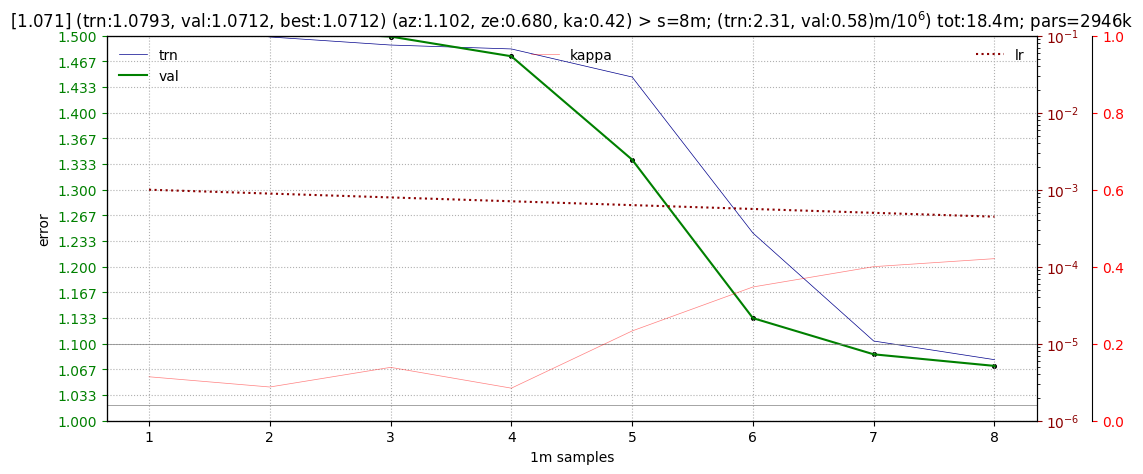

it:   9v[ 0]  100%  loss=-0.14458  error: 1.0668 (az: 1.098, ze: 0.649)  ( 512,  64,   3)   tm=27.5ms/step,  0.58m/1e6,  steps=1267         

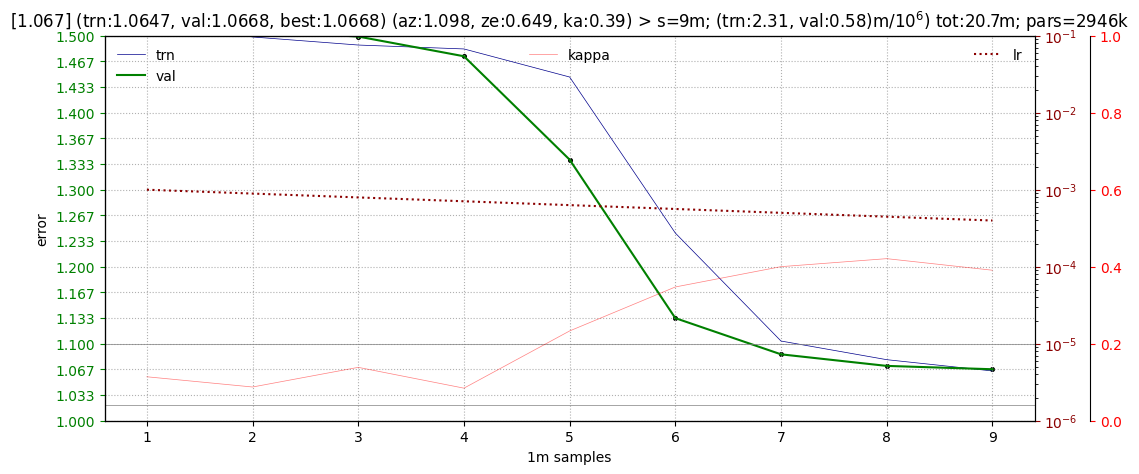

it:  10v[ 0]  100%  loss=-0.14585  error: 1.0612 (az: 1.089, ze: 0.623)  ( 512,  64,   3)   tm=27.5ms/step,  0.58m/1e6,  steps=1267         

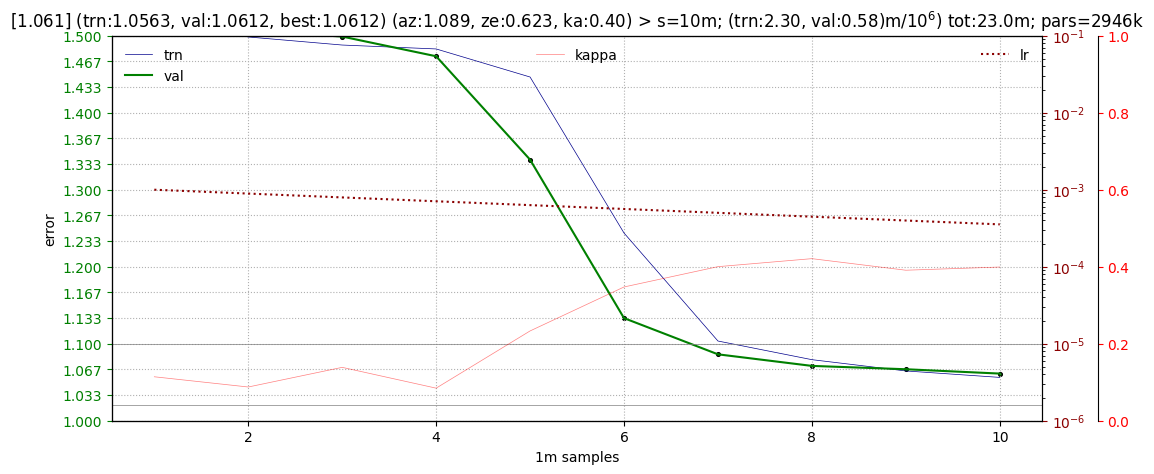

it:  11t[ 0]   18%  loss=-0.14199  error: 1.0582 (az: 1.088, ze: 0.641)  ( 256,  64,   3)   tm=50.2ms/step,  2.29m/1e6,  steps=2751         

KeyboardInterrupt: ignored

In [10]:
%%time
scaler = torch.cuda.amp.GradScaler()

def fit(dataset, it=0, train=True):
    model.train(train)     
    torch.set_grad_enabled(train)

    tot, drops, steps, beg, lst =  0, 0, 0, time.time(), time.time()
    scores, counts, kappas, samples = [], [], [], 0
    losses, errors, az_errs, ze_errs, kappas, counts = torch.zeros(0,).to(CFG.device), torch.zeros(0,).to(CFG.device), torch.zeros(0,).to(CFG.device), torch.zeros(0,).to(CFG.device), torch.zeros(0,).to(CFG.device), []
    #errors_all, samples_all = torch.zeros(0,).to(CFG.device), torch.zeros(0,)
    hist = []
    tm1, tm2, tm3, tm4 = 0,0,0,0
    for b, (EVENT_ID, SENSOR_ID, FEAT, AGG, Y, ERR) in enumerate(dataset):           
        samples += len(EVENT_ID)                
        if train and ERR is not None and ERR[0] > CFG.score*1.2:  # ???
            drops += len(EVENT_ID)                        
            continue                
        
        t = time.time()
        if dataset.device == 'cpu' and CFG.device != 'cpu':
            SENSOR_ID, FEAT, AGG, Y = SENSOR_ID.to(CFG.device), FEAT.to(CFG.device), AGG.to(CFG.device), Y.to(CFG.device)
        tm1 += time.time() - t
        
        t = time.time()                
        with torch.amp.autocast(device_type="cuda", dtype=CFG.dtype):
            loss, y,  ang_err, az_err, ze_err, kappa = model(SENSOR_ID, FEAT, AGG, Y)     

        #errors_all = torch.cat([errors_all, ang_err])                  
        ang_err, az_err, ze_err, kappa = ang_err.mean(), az_err.mean(), ze_err.mean(), kappa.mean()
        tm2 += time.time() - t

        t = time.time()
        if train:
            optimizer.zero_grad()   
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()                           
            CFG.samples += len(EVENT_ID)  # !!!!
            CFG.steps   += 1
        steps += 1
        #samples_all = torch.cat([samples_all, torch.Tensor([CFG.samples])])                  
        tm3 += time.time() - t                         

        t = time.time()
        losses = torch.cat([losses,  loss.detach().view(1,)])
        errors = torch.cat([errors,  ang_err.view(1,)])
        az_errs= torch.cat([az_errs, az_err.view(1,)])
        ze_errs= torch.cat([ze_errs, ze_err.view(1,)])
        kappas = torch.cat([kappas,  kappa.view(1,)])        
        counts.append(len(y)) 
        hist.append(FEAT.shape)
        tm4 += time.time() - t
        
        if time.time() - lst > 1 or b == len(dataset)-1:
            lst = time.time()
            error = (errors.cpu().numpy()*np.array(counts)).sum() / np.sum(counts)
            az_err= (az_errs.cpu().numpy()*np.array(counts)).sum() / np.sum(counts)
            ze_err= (ze_errs.cpu().numpy()*np.array(counts)).sum() / np.sum(counts)
            t0 = time.time()-beg                                                                                                            # drops={100*drops/samples:.2f}% of {samples/1e6:.3f}  t={100*tm1/t0:.0f}+{100*tm2/t0:.0f}+{100*tm3/t0:.0f}+{100*tm4/t0:.0f}={100*(tm1+tm2+tm3+tm4)/t0:.0f}
            print(f"\rit:{it:4d}{'t' if train else 'v'}[{dataset.file_id:2d}]  {100*(b+1)/len(dataset):3.0f}%  loss={np.mean(losses.cpu().numpy()):.5f}  error: {error:6.4f} (az:{az_err:6.3f}, ze:{ze_err:6.3f})  ({len(FEAT):4d},{FEAT.shape[1]:4d},{FEAT.shape[2]:4d})   tm={1000*(time.time()-beg)/steps:.1f}ms/step,  {(time.time()-beg)*1e6/(60*np.sum(counts)):.2f}m/1e6,  steps={len(dataset)}", end="         ")

    error = (errors.cpu().numpy()*np.array(counts)).sum()  / np.sum(counts)
    az_err= (az_errs.cpu().numpy()*np.array(counts)).sum() / np.sum(counts)
    ze_err= (ze_errs.cpu().numpy()*np.array(counts)).sum() / np.sum(counts)

    if False:
        plt.figure(figsize=(12,5), facecolor ='w')
        ax1 = plt.subplot(111)
        ax1.plot(errors.cpu().numpy(), "-r")
        ax2 = ax1.twinx()
        ax2.plot(np.array(hist).transpose()[1], "-b")
        #ax3 = ax1.twinx()
        #ax3.plot(np.array(hist).transpose()[0])
        plt.show()

    #return errors_all.cpu(), samples_all, error, az_err, ze_err, 0, kappas.mean().cpu().item(), (time.time()-beg)*1e6/(60*np.sum(counts))
    return error, az_err, ze_err, 0, kappas.mean().cpu().item(), (time.time()-beg)*1e6/(60*np.sum(counts)), samples

#-------------------------------------------------------------------------------

if True:   
    info("Good luck!")     
    error_trn, error_val, last_best,  beg, tm_trn, tm_val = 1.5, 3.1415, 0, time.time(), 0, 0
    kappa_val, kappa_trn, loss_trn, loss_val = 0, 0, 0,0
    az_err_val, ze_err_val = 0, 0
    CFG.lr = scheduler.get_lr()
    if len(history) > 0:
        error_trn, error_val, az_err_val, ze_err_val = history[-1][1], history[-1][2], history[-1][3], history[-1][4]         
        kappa_val, kappa_trn = history[-1][6],  history[-1][7]
        
    n_iters = 20
    
    if False:
        dataset_val.reset()        
        _, _, error_val, az_err_val, ze_err_val, loss_val, kappa_val, tm_val, samples_val = fit(dataset_val, 0, train=False)
        print()

    for it in tqdm( range(1, n_iters + 1)  ):                                               
        dataset_trn.reset()            # ?           
        CFG.lr = scheduler.get_lr()
        error_trn, az_err_trn, ze_err_trn, loss_trn, kappa_trn, tm_trn, samples_trn = fit(dataset_trn, it, train=True)        
        
        if it % 1 == 0 or it == n_iters:   # в конце валидация           
            dataset_val.reset()            # ?               
            error_val, az_err_val, ze_err_val, loss_val, kappa_val, tm_val, samples_val = fit(dataset_val, it, train=False)                                    

        history.append( (CFG.samples, error_trn, error_val, az_err_val, ze_err_val, CFG.steps, kappa_trn, kappa_val, CFG.lr, tm_trn, tm_val) )        
        save_model_checkpoint(model, error_val, error_trn, folder="/content/drive/MyDrive/IceCube/IceCube-Models/IceCube/checkpoints/")

        if error_val < CFG.score:                                
            save_best_model(model, error_val, folder="/content/drive/MyDrive/IceCube/IceCube-Models/IceCube/")
            CFG.score= round(error_val, 5)
            checks.append((CFG.samples, error_val))
            last_best  = it             

        if  it % 1  == 0 or it == n_iters:        
            plot(history, checks, labels, xmin=-100, ymin=1, ymax=1.50, ticks=16, info="")     
 
        if it % 1 == 0:                      # колбасит из-за новых батчей или lr?        
            dataset_trn.load_next() # !!!  

        scheduler.step(samples_trn)
